# **1. Introduction**

- **Objective** :  to identify a model that will be able to recognize and classify the handwritten digits from images.
- **Dataset** : For this analysis, we are using MNIST dataset which contains 60,000 training images & 10,000 testing images

# **2. Importing Neccessary libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import mnist
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras.optimizers import SGD
from keras.utils import to_categorical
import keras_tuner as kt
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# **3. Data Loading & Preprocessing**

In [ ]:
def load_data():
    # Loading the dataset from MNIST. Each image is of size 28*28 pixels. It is greyscale image.
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Pixel value of a grey scale image are unsigned integers with value ranges from 0(black)-255(white).
    # Normalize(Scaling) the pixel values to range between 0 & 1. Also the scaled value is converted to float value.
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255

    # Flatten the 28*28 images into 1D array
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)

    return x_train, y_train, x_test, y_test

# **4. Models**

# **4.1 KNN Classifier**

In [ ]:
def KNN_Classifier(x_train, y_train, x_test, y_test,neighbors):

    # creating an instance of the K-Nearest Neighbors classifier with 10 neighbors.
    knn = KNeighborsClassifier(n_neighbors=neighbors)

    # Fit & training the model
    knn.fit(x_train, y_train)

    # Predict on the test dataset
    knn_pred = knn.predict(x_test)

    # Accuracy is calculated comparing the predicted value & actual values(y_test)
    KNN_accuracy = accuracy_score(y_test, knn_pred)

    # Finally returning the calculated accuracy
    return KNN_accuracy

## **4.1.2 KNN - Hyper Parameter Tuning**

In [ ]:
def KNN_Classifier_HPT(x_train, y_train, x_test, y_test):

    # Define the parameter grid
    param_grid = {
      'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]
    }

    # Creating an instance of the K-Nearest Neighbors
    knn = KNeighborsClassifier()

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3)

    # Fit & train the model
    grid_search.fit(x_train, y_train)

    # Get the best parameters and accuracy score
    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_

    # Returning the best params & best acc score
    return best_params, best_accuracy

# **4.2 SVM**

In [ ]:
def SVM(x_train, y_train, x_test, y_test):

    # Initialize the SVM model with kernel, C & gamma value
    svm = SVC(kernel='rbf', C=5, gamma=0.05)

    # Fit & train the model
    svm.fit(x_train, y_train)

    # Predict on the test dataset
    SVM_pred = svm.predict(x_test)

    # Accuracy is calculated comparing the predicted value & actual values(y_test)
    SVM_accuracy = accuracy_score(y_test, SVM_pred)

    #Returns the SVM accuracy score
    return SVM_accuracy

## **4.2.1 SVM - Hyper Parameter tuning**

In [ ]:
def SVM_HPT(x_train, y_train, x_test, y_test):

    # Define the parameter grid
    param_grid = {
      'C': [0.1, 1, 10, 100],
      'gamma': [1, 0.1, 0.01, 0.001],
      'kernel': ['rbf']
    }

    # Initialize the SVM classifier
    svm = SVC()

    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, verbose=3)

    # Fit & train the model
    grid_search.fit(x_train, y_train)

    # Get the best parameters and accuracy
    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_

    # Printing the best params & its best acc score. Here were are not returning anything.
    print(f'Best parameters: {best_params}')
    print(f'Best cross-validation accuracy: {best_accuracy*100:.2f}%')

# **4.3 CNN**

In [ ]:
def prepare_data(x_train, y_train, x_test, y_test):

    # Reshaping the training & testing data suitable for CNN to process
    x_train = x_train.reshape(x_train.shape[0],28,28,1)
    x_test = x_test.reshape(x_test.shape[0],28,28,1)

    # Splitting the training & validation data. Here 10% data is used for validation
    (x_train,x_valid) = x_train[:54000],x_train[54000:]
    (y_train,y_valid) = y_train[:54000],y_train[54000:]

    # For training any neural networks, class labels to be converted into binary vectors.
    # We know that there are 10 classes and each is represented by unique integers. Before proceeding we need to convert these integers into a binary vector.
    # For this we will use one-hot encoding technique.
    # Ex : Integers 5 will be represented as [0,0,0,0,0,1,0,0,0,0]
    y_train = to_categorical(y_train,10)
    y_valid = to_categorical(y_valid,10)
    y_test = to_categorical(y_test,10)

    return x_train,y_train,x_test,y_test,x_valid,y_valid

In [ ]:
def load_CNN_Model(filters_1, kernel_size_1, pool_size_1, filters_2, kernel_size_2, pool_size_2, filters_3, kernel_size_3, pool_size_3,dropout_rate_1, dense_units, dropout_rate_2):

    #Load and prepare the data
    x_train, y_train, x_test, y_test = load_data()
    x_train,y_train,x_test,y_test,x_valid,y_valid = prepare_data(x_train, y_train, x_test, y_test)

    # Creating instance of Sequentail model
    CNNModel = Sequential()

    # Adding 3 layers of convulution & Pooling layers
    CNNModel.add(Conv2D(filters=filters_1,kernel_size=kernel_size_1,padding ='same',activation='relu',input_shape=(28,28,1))) # for grey scale image - x*y*1 & for color x*y*3
    CNNModel.add(MaxPooling2D(pool_size=pool_size_1))

    CNNModel.add(Conv2D(filters=filters_2,kernel_size=kernel_size_2,padding = 'same',activation='relu'))
    CNNModel.add(MaxPooling2D(pool_size=pool_size_2))

    CNNModel.add(Conv2D(filters=filters_3,kernel_size=kernel_size_3,padding ='same',activation='relu'))
    CNNModel.add(MaxPooling2D(pool_size=pool_size_3))

    # To prevent overfitting % of data is dropped at this stage
    CNNModel.add(Dropout(dropout_rate_1))

    # Converts 2D matrix data into Vector
    CNNModel.add(Flatten())

    CNNModel.add(Dense(dense_units,activation='relu'))
    CNNModel.add(Dropout(dropout_rate_2))
    CNNModel.add(Dense(10,activation='softmax'))

    CNNModel.summary()
    # Compiling the model
    CNNModel.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

    # Training the model and saving the best params at the location model.weights.best.keras
    from keras.callbacks import ModelCheckpoint
    checkpoint = ModelCheckpoint(filepath = 'model.weights.best.keras',verbose = 1, save_best_only = True)
    CNNModel.fit(x_train,y_train,batch_size=28,epochs=10,validation_data=(x_valid,y_valid),callbacks=[checkpoint],verbose = 1,shuffle=True)

    # Load the saved best params
    CNNModel.load_weights('model.weights.best.keras')

    # Evaluating the model
    CNNpred = CNNModel.predict(x_test)

    # Evaluating the Model accuracy
    test_loss, test_accuracy = CNNModel.evaluate(x_test, y_test, verbose=1)
    CNN_accuracy = test_accuracy
    return CNN_accuracy

In [ ]:
def CNN():
    # Setting the CNN model with below config
    # 3 convolutional layers with 16, 32, and 64 filters respectively.
    # Kernel sizes of 3x3 for each convolutional layer.
    # Pooling sizes of 2x2 for each max pooling layer.
    # Dropout rates of 0.3 after the convolutional layers and the dense layer.
    # A dense layer with 500 units.

    CNN_accuracy = load_CNN_Model(16,3,2,32,3,2,64,3,2,0.3,500,0.3)
    return CNN_accuracy

## **4.3.2 CNN- Hyper tuning**

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Choice('filters_1', values=[16, 32, 64]), kernel_size=hp.Choice('kernel_size_1', values=[3,5]), padding='same', activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=hp.Choice('pool_size_1', values=[2,3])))

    model.add(Conv2D(filters=hp.Choice('filters_2', values=[32, 64, 128]), kernel_size=hp.Choice('kernel_size_2', values=[3,5]), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=hp.Choice('pool_size_2', values=[2,3])))

    model.add(Conv2D(filters=hp.Choice('filters_3', values=[64, 128, 256]), kernel_size=hp.Choice('kernel_size_3', values=[3,5]), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=hp.Choice('pool_size_3', values=[2,3])))

    model.add(Dropout(rate=hp.Choice('dropout_rate', values=[0.2, 0.3, 0.4, 0.5])))
    model.add(Flatten())

    model.add(Dense(units=hp.Choice('dense_units', values=[128, 256, 512]), activation='relu'))
    model.add(Dropout(rate=hp.Choice('dropout_rate_2', values=[0.2, 0.3, 0.4, 0.5])))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def CNN_HPT_RS(x_train, y_train, x_test, y_test):

    #Load and prepare the data
    x_train,y_train,x_test,y_test,x_valid,y_valid = prepare_data(x_train, y_train, x_test, y_test)

    # Initializing the keras tuner for hyper parameter tuning
    tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='mnist_cnn_tuning'
    )
    # Keras tuner runs the hyperparameter search on the training data & validation data for evaluation.
    tuner.search(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid))

    # Saving the params found from the search
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Printing the best params found on the search
    print(f'Best hyperparameters: {best_hps.values}')

In [ ]:
def CNN_HPT():
    # Setting the CNN model with hyper parameter config
    # 3 convolutional layers with 32, 128 and 256 filters respectively.
    # Kernel sizes of 5*5 ,3x3 & 5*5 for each convolutional layer.
    # Pooling sizes of 2*2, 2*2 & 3*3 for each max pooling layer.
    # Dropout rates of 0.5 & 0.3 after the convolutional layers and the dense layer.
    # A dense layer with 512 units.

    CNN_HPT_accuracy = load_CNN_Model(32,5,2,128,3,2,256,5,3,0.5,512,0.3)
    return CNN_HPT_accuracy

# **4.4 Load Models**

In [ ]:
# Loading the training & testing values after processing from the load model
x_train, y_train, x_test, y_test = load_data()

In [ ]:
# KNN_Classifier model is loaded with training & testing values. Returned acc score is saved in KNN_accuracy variable.
KNN_accuracy = KNN_Classifier(x_train, y_train, x_test, y_test,10)

In [ ]:
# # KNN_Classifier model is loaded with training & testing values. This method gives best params for KNN Classifier.
# best_params, best_accuracy = KNN_Classifier_HPT(x_train, y_train, x_test, y_test)
# print('best_params',best_params)
# print('best_accuracy',best_accuracy)
#----------------------------------------------------------
# best_params {'n_neighbors': 3}
# best_accuracy 0.9700666666666666

In [ ]:
# KNN classifier is loaded with best_params =3
KNN_HPT_accuracy = KNN_Classifier(x_train, y_train, x_test, y_test,3)

In [ ]:
# SVM model is loaded with training & testing values. Returned acc score is saved in SVM_accuracy variable.
SVM_accuracy = SVM(x_train, y_train, x_test, y_test)

#SVM hypertuning method is loaded with training & testing values. This method gives best params for SVM.
#SVM_HPT(x_train, y_train, x_test, y_test)

In [ ]:
# CNN model is loaded with default params & hyper paramater params
CNN_accuracy = CNN()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 3, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 500)                 │         288,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 316,806 (1.21 MB)

 Trainable params: 316,806 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8639 - loss: 0.4200
Epoch 1: val_loss improved from inf to 0.05015, saving model to model.weights.best.keras
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.8640 - loss: 0.4199 - val_accuracy: 0.9858 - val_loss: 0.0502
Epoch 2/10
1924/1929 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9778 - loss: 0.0712
Epoch 2: val_loss improved from 0.05015 to 0.04384, saving model to model.weights.best.keras
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9778 - loss: 0.0712 - val_accuracy: 0.9867 - val_loss: 0.0438
Epoch 3/10
1925/1929 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9838 - loss: 0.0532
Epoch 3: val_loss improved from 0.04384 to 0.02942, saving model to model.weights.best.keras
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.9838 - loss: 0.0532 - val_accuracy: 0.9923 - val_loss: 0.0294
Epoch 4/10
1927/1929 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9882 - loss: 0.0390
Epoch 4:

In [ ]:
# run the below method to get the best params.
# Note: Execution time may take 3-4 hours
#CNN_HPT_RS

# Runs approximately 3.30 hours
'''Trial 5 Complete [01h 18m 37s]
val_accuracy: 0.9939444661140442

Best val_accuracy So Far: 0.9939444661140442
Total elapsed time: 02h 50m 34s
Best hyperparameters: {'filters_1': 32, 'kernel_size_1': 5, 'pool_size_1': 2,
                       'filters_2': 128, 'kernel_size_2': 3, 'pool_size_2': 2,
                       'filters_3': 256, 'kernel_size_3': 5, 'pool_size_3': 3,
                       'dropout_rate': 0.5, 'dense_units': 512, 'dropout_rate_2': 0.3}'''

In [ ]:
#Obtained best params are passed in this method.
CNN_HPT_accuracy = CNN_HPT()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 128)         │          36,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,387,210 (5.29 MB)

 Trainable params: 1,387,210 (5.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8747 - loss: 0.3716
Epoch 1: val_loss improved from inf to 0.03868, saving model to model.weights.best.keras
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 75s 38ms/step - accuracy: 0.8748 - loss: 0.3715 - val_accuracy: 0.9885 - val_loss: 0.0387
Epoch 2/10
1928/1929 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9820 - loss: 0.0589
Epoch 2: val_loss improved from 0.03868 to 0.02616, saving model to model.weights.best.keras
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.9820 - loss: 0.0589 - val_accuracy: 0.9922 - val_loss: 0.0262
Epoch 3/10
1928/1929 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9877 - loss: 0.0425
Epoch 3: val_loss did not improve from 0.02616
1929/1929 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - accuracy: 0.9877 - loss: 0.0425 - val_accuracy: 0.9907 - val_loss: 0.0353
Epoch 4/10
1928/1929 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9890 - loss: 0.0354
Epoch 4: val_loss did not improve from 0.02616
1929/

# **5. Results**

## 5.1 Evaluation
#### Accuracy score for each model is below:
  - **KNN Accuracy: 96.65%**
  - **KNN_HPT Accuracy: 97.05%**
  - **SVM Accuracy: 98.37%**
  - **CNN Accuracy: 99.26%**
  - **CNN_HPT Accuracy: 99.24%**

## 5.2 Visualization of Accuracy scores

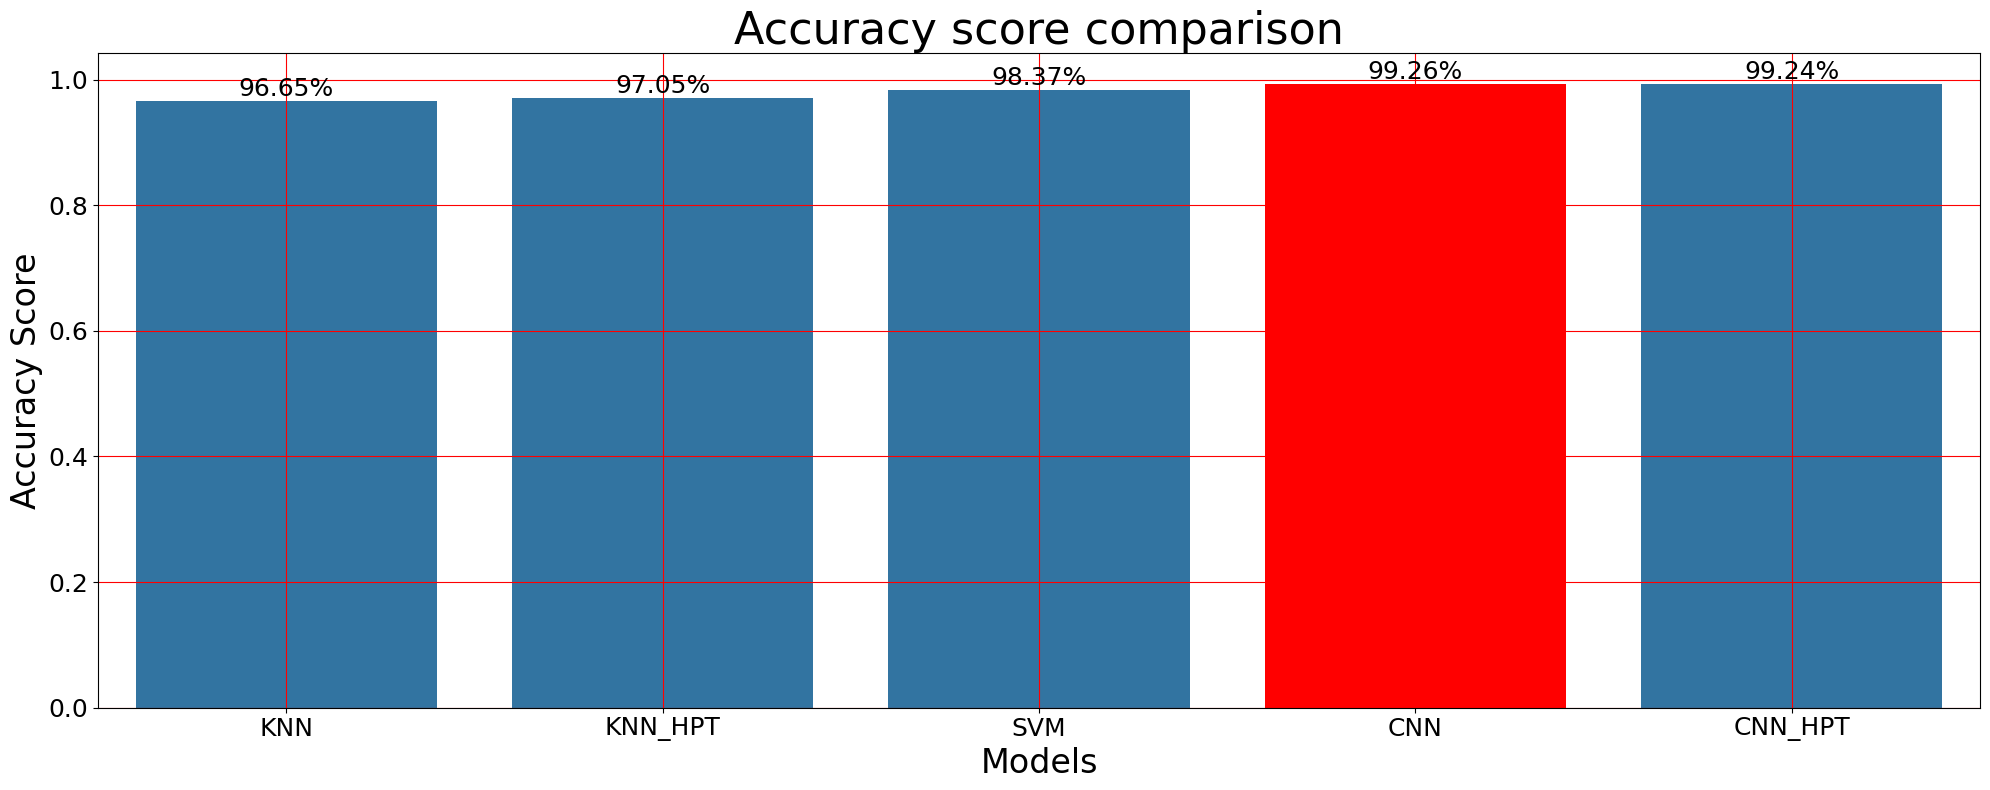

In [ ]:
plt.figure(figsize=(20,8))

# Creating the data dictionary with model names in x-axis & model acc score in y-axis
data = {'model' : ['KNN','KNN_HPT','SVM','CNN','CNN_HPT'],
        'values' : [KNN_accuracy,KNN_HPT_accuracy,SVM_accuracy,CNN_accuracy,CNN_HPT_accuracy]}

#converting the dictionary into Dataframe
df = pd.DataFrame(data)

df['Percentage'] = (df['values']) * 100

# Create bar plot
ax = sns.barplot(x = 'model',y = 'values', data=df)

# Add labels to the bars
for container in ax.containers:
    labels = [f'{v:.2f}%' for v in df['Percentage']]
    ax.bar_label(container,labels = labels,fontsize = 18)

# Finding the bar with the maximum value
max_value = df['values'].max()
max_index = df['values'].idxmax()

# Setting red color to the bar which has max value
ax.patches[max_index].set_facecolor('red')

# Plotting the bar plot
plt.grid(color='r')
plt.title('Accuracy score comparison',fontsize = 32)
plt.xlabel('Models',fontsize = 24)
plt.ylabel('Accuracy Score',fontsize = 24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()

# **6. Conclusion**

- **Summary**: CNN outperformed other models with an accuracy of 99.26%. There is no major improvement with CNN hyper parameter tuning. Hence from the above results, concluding CNN is the best model to predict Handwritten digits for MNIST dataset.